In [1]:
import os
import scenic
scenic_script = "./examples/carla/ICCV_Scenic_Experiments/scenicScenario1.scenic"
scenario = scenic.scenarioFromFile(scenic_script)

/Users/edwardkim/Desktop/Scenic_Query/Scenic/src/scenic/core/errors.py:160: UserWarning: unable to install sys.excepthook to format Scenic backtraces
  warnings.warn('unable to install sys.excepthook to format Scenic backtraces')


globalParameters.map:  /Users/edwardkim/Desktop/Scenic_Query/Scenic/examples/carla/ICCV_Scenic_Experiments/../../../tests/formats/opendrive/maps/CARLA/Town01.xodr
globalParameters.map_options:  {}


/Users/edwardkim/Desktop/Scenic_Query/Scenic/src/scenic/simulators/carla/model.scenic:56: UserWarning: the "carla" package is not installed; will not be able to run dynamic simulations
  warnings.warn('the "carla" package is not installed; '


In [5]:
x = scenario.original_objects[2].position
print(type(x))
print(x)

<class 'scenic.core.vectors.VectorOperatorDistribution'>
<VectorField roadDirection>.followFrom(PointIn(<SectorRegion>).offsetRotated(<VectorField roadDirection>.__getitem__(PointIn(<SectorRegion>)), (0 @ 2.25)), Range(2.0, 5.0)).offsetRotated(<VectorField roadDirection>.__getitem__(<VectorField roadDirection>.followFrom(PointIn(<SectorRegion>).offsetRotated(<VectorField roadDirection>.__getitem__(PointIn(<SectorRegion>)), (0 @ 2.25)), Range(2.0, 5.0))), (Range(-0.5, 0.5).__radd__(0.0) @ 0)).offsetRotated(<VectorField roadDirection>.__getitem__(<VectorField roadDirection>.followFrom(PointIn(<SectorRegion>).offsetRotated(<VectorField roadDirection>.__getitem__(PointIn(<SectorRegion>)), (0 @ 2.25)), Range(2.0, 5.0)).offsetRotated(<VectorField roadDirection>.__getitem__(<VectorField roadDirection>.followFrom(PointIn(<SectorRegion>).offsetRotated(<VectorField roadDirection>.__getitem__(PointIn(<SectorRegion>)), (0 @ 2.25)), Range(2.0, 5.0))), (Range(-0.5, 0.5).__radd__(0.0) @ 0))).__radd__

In [1]:
from scenic.core.vectors import OrientedVector, Vector
import matplotlib.pyplot as plt
from scenic.core.type_support import toVector
from scenic.core.regions import PolygonalRegion, PointInRegionDistribution, SectorRegion
import os.path as path
from scenic.core.regions import SectorRegion
from scenic.core.geometry import triangulatePolygon, normalizeAngle
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from scenic.core.distributions import *
import math
import subprocess
import os


# TODO : need to handle jointly dependent objs as well
def isFeatureValid(feature, label, smt_file_path, cached_variables, featureType, debug=False, falseTesting=False):
    
    # TODO : need to handle jointly dependent objs as well
    if os.path.isfile(smt_file_path):
        os.remove(smt_file_path)
    
    open(smt_file_path, 'w').close()
    writeSMTtoFile(smt_file_path, '(set-logic QF_NRA)')

    # Instantiate cached_variables dictionary
    x, y, label_feature = None,None,None
    
    if not falseTesting:
        if featureType == 'position':
            label_feature = (str(label.x), str(label.y))
        if featureType == 'heading':
            label_feature = str(label)
    else:
        x = 1144.11438466291
        y = 1085.6681557273737
        heading = -0.293950447126917
        if featureType == 'position':
            label_feature = (str(x), str(y))
        
        
    # Encode object's position to SMT formula
    smt_var = feature.encodeToSMT(smt_file_path, cached_variables, debug = debug)
    
    if featureType == 'position':
        (x_cond, y_cond) = vector_operation_smt(label_feature, "equal", smt_var)
        writeSMTtoFile(smt_file_path, smt_assert(None, smt_and(x_cond, y_cond)))
    else:
        writeSMTtoFile(smt_file_path, smt_assert(None, smt_equal(label_feature, smt_var)))
    writeSMTtoFile(smt_file_path, "(check-sat)")
    writeSMTtoFile(smt_file_path, "(exit)")

    if not debug:
        if subprocess.call("./run_smt_encoding.sh") == 1:
            return True
        else:
            return False
    else:
        print("DEBUG MODE: NO OUTPUT WILL BE RETURNED")
            
    return None


def validateLabel(scenario, img_name, debug=False, falseTesting=False, scenic_testing=False):
    ego_visibleDistance = 100 #meters
    ego_viewAngle = 120 #deg
    smt_file_path = './test_smt_encoding.smt2'
    
    resetScenarioDependency(scenario)
    
    label, ego_label, vehicles_label, pedestrians_label = None, None, None, None
    if not scenic_testing:
        label = nusc.get_img_data(img_name)
        ego_label = label['EgoCar']
        vehicles_label = label['Vehicles']
        pedestrians_label = label['Pedestrians']
        (x_ego, y_ego) = ego_label['position']
        label_ego_pos = Vector(x_ego, y_ego)
#         label_ego_heading = normalizeAngle(math.radians(label['EgoCar']['heading']+90))
        label_ego_heading = math.radians(label['EgoCar']['heading']+90)
        
    else:
        if not falseTesting:
            sample = scenario.generate()
            label = sample[0]
            ego_label = label.objects[0]
            vehicles_label = [label.objects[i+1] for i in range(len(label.objects)-1)]
            label_ego_pos = ego_label.position
            label_ego_heading = ego_label.heading
        else:
            x = 1144.11438466291
            y = 1085.6681557273737
            label_ego_pos = Vector(x,y)
            label_ego_heading = -0.293950447126917
    
    # Create Ego's VisibleRegion
    cached_variables = {}
    cached_variables['variables'] = []
    egoVisibleRegion = SectorRegion(label_ego_pos, ego_visibleDistance, label_ego_heading, \
                                    math.radians(ego_viewAngle))
    cached_variables['egoVisibleRegion'] = egoVisibleRegion
    
    ## Validate EgoCar label
    if not checkPosHeading(scenario.objects[0], ego_label, smt_file_path, cached_variables, \
                           debug, falseTesting, scenic_testing):
        return False
    
    ## Validate Other agents' labels
    # create a permutation of all label's Vehicles
    obj_labels = None
    if 'Pedestrian' in str(scenario.objects[1]):
        print("PERMUTING PEDESTRIANS")
        if len(pedestrians_label)==0:
            print("NO PEDESTRIAN AVAILABLE!")
            return False
        permutation = permutedIndexSet(pedestrians_label)
        obj_labels = pedestrians_label
    else:
        print("PERMUTING VEHICLES")
        permutation = permutedIndexSet(vehicles_label)
        obj_labels = vehicles_label
    feasible_permutation = permutation
    
    # try permutations of label matching
    for p in permutation:
        if p not in feasible_permutation:
            continue
            
        (boolean, failed_permutation) = tryPermutation(p, obj_labels, scenario, smt_file_path, \
                                                       cached_variables, debug, falseTesting, scenic_testing)
        if not boolean:
            feasible_permuation = removeInfeasiblePermutation(failed_permutation, permutation)
            # Need reset conditioned objects with wrong permutation of labels
            resetScenarioDependency(scenario)
            # reset cached_variables dictionary
            resetDictionary(cached_variables, egoVisibleRegion)
            # Ego's label is valid so keep that conditioned obj
            checkPosHeading(scenario.objects[0], label['EgoCar'], smt_file_path, cached_variables, \
                           debug, falseTesting)
        else:
            if scenario.checkRequirements():
                return True
            else:
                feasible_permuation = removeInfeasiblePermutation(failed_permutation, permutation)
                # Need reset conditioned objects with wrong permutation of labels
                resetScenarioDependency(scenario)
                # reset cached_variables dictionary
                resetDictionary(cached_variables, egoVisibleRegion)
                # Ego's label is valid so keep that conditioned obj
                checkPosHeading(scenario.objects[0], label['EgoCar'], smt_file_path, cached_variables, \
                               debug, falseTesting)
            

    return True 

def tryPermutation(permutation_tuple, label_objs, scenario, smt_file_path, cached_variables, \
                           debug=False, falseTesting=False, scenic_testing=False):
    failed_index_sequence = []
    for i in range(len(scenario.objects)-1):
        index = permutation_tuple[i]
        
        label_obj = label_objs[index]
        scenic_obj= scenario.objects[i+1]
        if checkPosHeading(scenic_obj, label_obj, smt_file_path, cached_variables, \
                           debug, falseTesting, scenic_testing):
            failed_index_sequence.append(index)
        else:
            failed_index_sequence.append(index)
            return (False, failed_index_sequence)
    return (True, None)
    
def checkPosHeading(scenic_obj, label_obj, smt_file_path, cached_variables, debug=False, falseTesting=False,\
                   scenic_testing=False):
    if not scenic_testing:
        (x,y) = label_obj['position']
    else:
        (x,y) = label_obj.position
        
    label_feature = Vector(x,y)
    print("position: ", label_feature)
    feature = scenic_obj.position
    if isFeatureValid(feature, label_feature, smt_file_path, cached_variables, \
                      featureType='position', \
                      debug=debug, falseTesting=falseTesting):
        print("POSITION IS VALID")
        # condition the validated feature with the label's feature
        feature.conditionTo(label_feature)
    else:
        print("NOT VALID: POSITION")
        return False

    if not scenic_testing:
        heading = label_obj['heading'] + 90
        label_feature = math.radians(heading)
    else:
        heading = label_obj.heading
        label_feature = heading
    print("heading: ", label_feature)
    feature = scenic_obj.heading
    if isFeatureValid(feature, label_feature, smt_file_path, cached_variables, \
                      featureType='heading', \
                      debug=debug, falseTesting=falseTesting): 
        print("heading is valid")
        # condition the validated feature with the label's feature
        feature.conditionTo(Constant(label_feature))
    else:
        print("NOT VALID: HEADING")
        return False
    return True

def permutedIndexSet(label_objs):
    index_list = [i for i in range(len(label_objs))]
    return set(itertools.permutations(index_list))

# def permutedIndexSetTesting(index_list):
# #     index_list = [i for i in range(len(label['Vehicles']))]
#     return set(itertools.permutations(index_list))

def removeInfeasiblePermutation(failed_list, permutation_set):
    infeasible_permutation = set()
    for p_tuple in permutation_set:
        if tupleStartsWith(failed_list, p_tuple):
            infeasible_permutation.add(p_tuple)
    return permutation_set.difference(infeasible_permutation)
            
def tupleStartsWith(failed_list, permutation_tuple):
    for i in range(len(failed_list)):
        if failed_list[i] != permutation_tuple[i]:
            return False
    return True

def resetDictionary(cached_variables, egoVisibleRegion):
    cached_variables = {}
    cached_variables['variables'] = []
    cached_variables['egoVisibleRegion'] = egoVisibleRegion
        
def resetScenarioDependency(scenario):
    for obj in scenario.objects:
        resetConditionedVar(obj.position)
        resetConditionedVar(obj.heading)

def resetConditionedVar(obj):
    obj._conditioned = obj
    if (obj._dependencies is None):
        return None
    for dep in obj._dependencies:
        resetConditionedVar(dep)
    return None

# directory = '/Users/edwardkim/Desktop/Scenic_Query/nuscenes_data/experiment_folder/experiment'
# filenames = os.listdir(directory)
# print("label validity: ", validateLabel(scenario, None ,debug=False, falseTesting=False, scenic_testing=True))

# print(validateLabelTesting(scenario, debug=False, falseTesting=False))

/Users/edwardkim/Desktop/Scenic_Query/Scenic/src/scenic/core/errors.py:160: UserWarning: unable to install sys.excepthook to format Scenic backtraces
  warnings.warn('unable to install sys.excepthook to format Scenic backtraces')


In [4]:
import os
import scenic
scenic_script = "./examples/carla/test1.scenic"
scenario = scenic.scenarioFromFile(scenic_script)

/Users/edwardkim/Desktop/Scenic_Query/Scenic/src/scenic/simulators/carla/model.scenic:56: UserWarning: the "carla" package is not installed; will not be able to run dynamic simulations
  warnings.warn('the "carla" package is not installed; '


i:  0
position:  (34.29218818206131 @ 47.37734414056533)


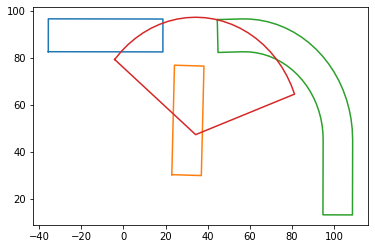

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x12505b3d0>, <shapely.geometry.polygon.Polygon object at 0x125fa5f40>, <shapely.geometry.polygon.Polygon object at 0x127f90640>]


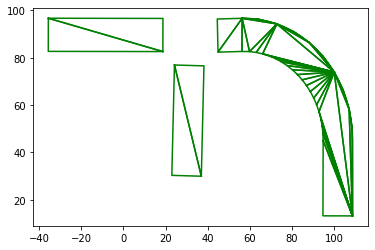

position is valid
heading:  -0.171168233421227
heading is valid
cached_variables {'variables': [], 'egoVisibleRegion': SectorRegion((34.29218818206131 @ 47.37734414056533),50,-0.171168233421227,2.0943951023931953)}
i:  1
position:  (35.52710697361955 @ 54.5213959025738)
in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x12505b3d0>, <shapely.geometry.polygon.Polygon object at 0x125fa5f40>, <shapely.geometry.polygon.Polygon object at 0x127f90640>]


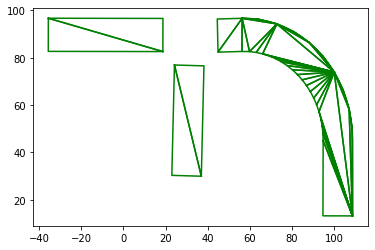

DEBUG MODE: NO OUTPUT WILL BE RETURNED
NOT VALID: POSITION
False


In [18]:
def resetDictionary(cached_variables, egoVisibleRegion):
    cached_variables.clear()
    cached_variables['variables'] = []
    cached_variables['egoVisibleRegion'] = egoVisibleRegion
    
def validateLabelTesting(scenario, cached_variables, debug=False, falseTesting=False):
    ego_visibleDistance = 50 #meters
    ego_viewAngle = 120 #deg
    smt_file_path = './test_smt_encoding.smt2'
    
    resetScenarioDependency(scenario)
    
    if not falseTesting:
        sample = scenario.generate()
        scene = sample[0]
        label_ego_pos = scene.objects[0].position
        label_ego_heading = scene.objects[0].heading
    else:
        x = 1144.11438466291
        y = 1085.6681557273737
        label_ego_pos = Vector(x,y)
        label_ego_heading = -0.293950447126917
    
    # Create Ego's VisibleRegion
#     cached_variables = {}
    cached_variables['variables'] = []
    egoVisibleRegion = SectorRegion(label_ego_pos, ego_visibleDistance, label_ego_heading, \
                                    math.radians(ego_viewAngle))
    cached_variables['egoVisibleRegion'] = egoVisibleRegion
    count = 0 
    
    for i in range(len(scenario.objects)):
        if count >0:
            debug = True
        print("i: ",i)
        obj = scenario.objects[i]
        label_feature = scene.objects[i].position
        print("position: ", label_feature)
        feature = obj.position
        if isFeatureValid(feature, label_feature, smt_file_path, cached_variables, featureType='position', \
                          debug=debug, falseTesting=falseTesting):
            print("position is valid")
            # condition the validated feature with the label's feature
            feature.conditionTo(label_feature)
        else:
            print("NOT VALID: POSITION")
            return False

        label_feature = scene.objects[i].heading
        print("heading: ", label_feature)
        feature = obj.heading
        if isFeatureValid(feature, label_feature, smt_file_path, cached_variables, featureType='heading', \
                          debug=debug, falseTesting=falseTesting): 
            print("heading is valid")
            # condition the validated feature with the label's feature
            feature.conditionTo(label_feature)
        else:
            print("NOT VALID: HEADING")
            return False
        
        count+=1
        
        resetDictionary(cached_variables, egoVisibleRegion)
        print('cached_variables', cached_variables)
    
    ## Check Hard Constraint Satisfaction
    if not scenario.checkRequirements():
        return False
    
    return True 

cached_variables = {}
print(validateLabelTesting(scenario, cached_variables, debug=False, falseTesting=False))

In [11]:
cached_variables

{'variables': ['x1',
  'y1',
  '-159.83927414533855',
  '-4.195236784887171',
  '-1.5683622814398157',
  'x2',
  'y2',
  'x3',
  'y3',
  'x4',
  'y4',
  'x5',
  'y5',
  's1',
  't1',
  'opdist1',
  'opdist2',
  'range1',
  'r',
  'a',
  'n',
  'g',
  'e',
  '1',
  'o',
  'p',
  'd',
  'i',
  's',
  't',
  '2',
  '-',
  '.',
  '5',
  '6',
  '8',
  '3',
  '4',
  '9',
  '7',
  'x6',
  'y6',
  'x7',
  'y7'],
 'egoVisibleRegion': SectorRegion((-159.83927414533855 @ -4.195236784887171),50,-1.8133427498645882,2.356194490192345),
 (-159.83927414533855 @ -4.195236784887171): ('-159.83927414533855',
  '-4.195236784887171',
  '-1.5683622814398157'),
 <scenic.core.vectors.VectorOperatorDistribution at 0x125443610>: ('x3', 'y3'),
 <scenic.core.vectors.VectorOperatorDistribution at 0x125498c10>: ('x5', 'y5'),
 SectorRegion((-159.83927414533855 @ -4.195236784887171),50,-1.8133427498645882,2.356194490192345): ('x1',
  'y1'),
 PolygonalRegion(MULTIPOLYGON (((-111.4065668074236 5.929472380748534, -61.76

2
file:  n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920162404.jpg
position:  (1927.3625156512157 @ 1053.3215015295318)


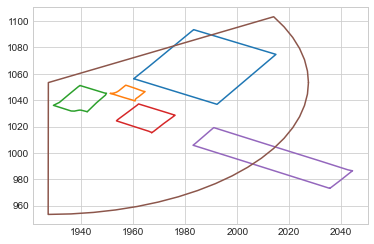

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x30f7fd6a0>, <shapely.geometry.polygon.Polygon object at 0x30fd22730>, <shapely.geometry.polygon.Polygon object at 0x310a17370>, <shapely.geometry.polygon.Polygon object at 0x3112e2af0>, <shapely.geometry.polygon.Polygon object at 0x312033490>]


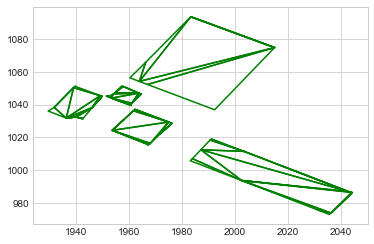

NOT VALID: POSITION
VALID:  False


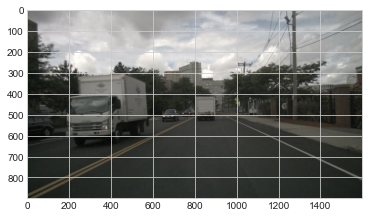

file:  n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920662404.jpg
position:  (1924.487978925326 @ 1055.023391492282)


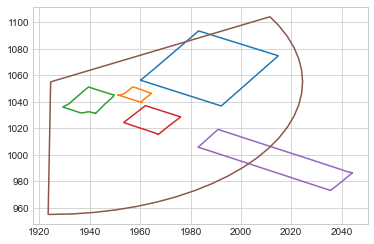

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x30f7fd6a0>, <shapely.geometry.polygon.Polygon object at 0x30fd22730>, <shapely.geometry.polygon.Polygon object at 0x310a17370>, <shapely.geometry.polygon.Polygon object at 0x3112e2af0>, <shapely.geometry.polygon.Polygon object at 0x312033490>]


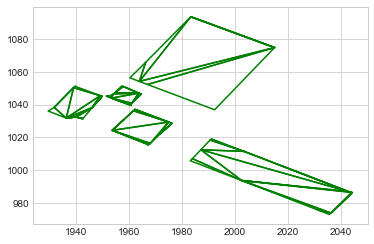

NOT VALID: POSITION
VALID:  False


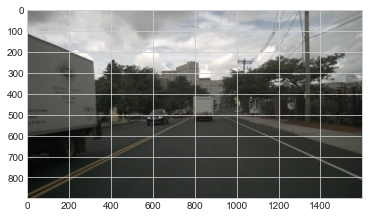

In [15]:
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

directory = '/Users/edwardkim/Desktop/Scenic_Query/nuscenes_data/experiment_results'
subject1 = 'experiment_result_JayShenoy'
subject2 = 'experiment_result_TaeSung'
subject3 = 'experiment_result_Xiangyu'
scenario_list = ['scenario1','scenario2','scenario3','scenario4','scenario5']

dir3 = os.path.join(directory, 'scenario4_intersection')
# dir3 = os.path.join(directory, subject3, 'scenario3')
filenames = [file for file in os.listdir(dir3) if file.endswith('.jpg')]
print(len(filenames))

resetScenarioDependency(scenario)

query_directory = os.path.join(directory, 'scenario4_queried')
if not os.path.isdir(query_directory):
    os.mkdir(query_directory)

for file in filenames:
    print("file: ", file)
    valid = validateLabel(scenario, file, debug=False, falseTesting=False, scenic_testing=False)
    print("VALID: ", valid)
    if valid:  
        shutil.copy(os.path.join(dir3, file), query_directory)
    img = mpimg.imread(os.path.join(dir3, file))
    imgplot = plt.imshow(img)
    plt.show()


i:  0
position:  (1141.0049286685594 @ 1381.264191639807)


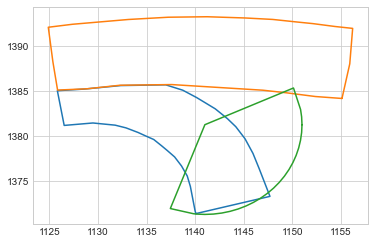

in Options class, polygonalRegions:  [<shapely.geometry.polygon.Polygon object at 0x34b2e5a30>, <shapely.geometry.polygon.Polygon object at 0x34d46b850>]


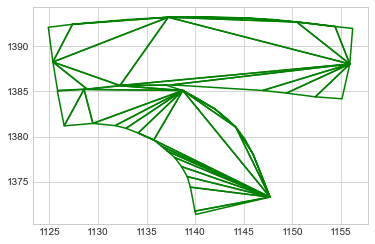

position is valid
heading:  -2.3273065742051595
heading is valid
True


In [30]:
print(validateLabelTesting(scenario, debug=False, falseTesting=False))

In [ ]:
scenario.egoObject.position.region.dist.options[0].value.

In [ ]:
import math
from scenic.core.vectors import Vector
(x,y) = label['EgoCar']['position']
math.degrees(scenario.objects[0].position.region.options[0].network.roadDirection.__getitem__(Vector(x,y)))

In [ ]:
humans_filenames = set(os.listdir(os.path.join(directory, 'scenario1_intersection')))
queried_filenames = set(os.listdir(os.path.join(directory, 'scenario1_queried')))
diff = humans_filenames.difference(queried_filenames)
print(len(diff))
for file in diff:
    shutil.copy(os.path.join(os.path.join(directory, 'scenario1_intersection'),file), directory)
    img = mpimg.imread(os.path.join(os.path.join(directory, 'scenario1_intersection',file)))
    imgplot = plt.imshow(img)
    plt.show()


In [ ]:
from scenic.core.vectors import OrientedVector, Vector
import matplotlib.pyplot as plt
from scenic.core.type_support import toVector
from scenic.core.regions import PolygonalRegion, PointInRegionDistribution, SectorRegion
import os.path as path
from scenic.core.regions import SectorRegion
from scenic.core.geometry import triangulatePolygon, normalizeAngle
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from scenic.core.distributions import *
import math
import subprocess
import os


# TODO : need to handle jointly dependent objs as well
def isFeatureValid(feature, label, smt_file_path, cached_variables, featureType, debug=False, falseTesting=False):
    
    # TODO : need to handle jointly dependent objs as well
    if os.path.isfile(smt_file_path):
        os.remove(smt_file_path)
    
    open(smt_file_path, 'w').close()
    writeSMTtoFile(smt_file_path, '(set-logic QF_NRA)')

    # Instantiate cached_variables dictionary
    x, y, label_feature = None,None,None
    
    if not falseTesting:
        if featureType == 'position':
            label_feature = (str(label.x), str(label.y))
        if featureType == 'heading':
            label_feature = str(label)
    else:
        x = 1144.11438466291
        y = 1085.6681557273737
        heading = -0.293950447126917
        if featureType == 'position':
            label_feature = (str(x), str(y))
        
        
    # Encode object's position to SMT formula
    smt_var = feature.encodeToSMT(smt_file_path, cached_variables, debug = debug)
    
    if featureType == 'position':
        (x_cond, y_cond) = vector_operation_smt(label_feature, "equal", smt_var)
        writeSMTtoFile(smt_file_path, smt_assert(None, smt_and(x_cond, y_cond)))
    else:
        writeSMTtoFile(smt_file_path, smt_assert(None, smt_equal(label_feature, smt_var)))
    writeSMTtoFile(smt_file_path, "(check-sat)")
    writeSMTtoFile(smt_file_path, "(exit)")

    if not debug:
        if subprocess.call("./run_smt_encoding.sh") == 1:
            return True
        else:
            return False
    else:
        print("DEBUG MODE: NO OUTPUT WILL BE RETURNED")
            
    return None


def validateLabel(scenario, img_name, debug=False, falseTesting=False, scenic_testing=False):
    ego_visibleDistance = 100 #meters
    ego_viewAngle = 120 #deg
    smt_file_path = './test_smt_encoding.smt2'
    
    resetScenarioDependency(scenario)
    
    label, ego_label, vehicles_label, pedestrians_label = None, None, None, None
    if not scenic_testing:
        label = nusc.get_img_data(img_name)
        ego_label = label['EgoCar']
        vehicles_label = label['Vehicles']
        pedestrians_label = label['Pedestrians']
        (x_ego, y_ego) = ego_label['position']
        label_ego_pos = Vector(x_ego, y_ego)
#         label_ego_heading = normalizeAngle(math.radians(label['EgoCar']['heading']+90))
        label_ego_heading = math.radians(label['EgoCar']['heading']+90)
        
    else:
        if not falseTesting:
            sample = scenario.generate()
            label = sample[0]
            ego_label = label.objects[0]
            vehicles_label = [label.objects[i+1] for i in range(len(label.objects)-1)]
            label_ego_pos = ego_label.position
            label_ego_heading = ego_label.heading
        else:
            x = 1144.11438466291
            y = 1085.6681557273737
            label_ego_pos = Vector(x,y)
            label_ego_heading = -0.293950447126917
    
    # Create Ego's VisibleRegion
    cached_variables = {}
    cached_variables['variables'] = []
    egoVisibleRegion = SectorRegion(label_ego_pos, ego_visibleDistance, label_ego_heading, \
                                    math.radians(ego_viewAngle))
    cached_variables['egoVisibleRegion'] = egoVisibleRegion
    
    ## Validate EgoCar label
    if not checkPosHeading(scenario.objects[0], ego_label, smt_file_path, cached_variables, \
                           debug, falseTesting, scenic_testing):
        return False
    
    ## Validate Other agents' labels
    # create a permutation of all label's Vehicles
    obj_labels = None
    if 'Pedestrian' in str(scenario.objects[1]):
        print("PERMUTING PEDESTRIANS")
        if len(pedestrians_label)==0:
            print("NO PEDESTRIAN AVAILABLE!")
            return False
        permutation = permutedIndexSet(pedestrians_label)
        obj_labels = pedestrians_label
    else:
        print("PERMUTING VEHICLES")
        permutation = permutedIndexSet(vehicles_label)
        obj_labels = vehicles_label
    feasible_permutation = permutation
    
    # try permutations of label matching
    for p in permutation:
        if p not in feasible_permutation:
            continue
            
        (boolean, failed_permutation) = tryPermutation(p, obj_labels, scenario, smt_file_path, \
                                                       cached_variables, debug, falseTesting, scenic_testing)
        if not boolean:
            feasible_permuation = removeInfeasiblePermutation(failed_permutation, permutation)
            # Need reset conditioned objects with wrong permutation of labels
            resetScenarioDependency(scenario)
            # reset cached_variables dictionary
            resetDictionary(cached_variables, egoVisibleRegion)
            # Ego's label is valid so keep that conditioned obj
            checkPosHeading(scenario.objects[0], label['EgoCar'], smt_file_path, cached_variables, \
                           debug, falseTesting)
        else:
            if scenario.checkRequirements():
                return True
            else:
                feasible_permuation = removeInfeasiblePermutation(failed_permutation, permutation)
                # Need reset conditioned objects with wrong permutation of labels
                resetScenarioDependency(scenario)
                # reset cached_variables dictionary
                resetDictionary(cached_variables, egoVisibleRegion)
                # Ego's label is valid so keep that conditioned obj
                checkPosHeading(scenario.objects[0], label['EgoCar'], smt_file_path, cached_variables, \
                               debug, falseTesting)
            

    return True 

def tryPermutation(permutation_tuple, label_objs, scenario, smt_file_path, cached_variables, \
                           debug=False, falseTesting=False, scenic_testing=False):
    failed_index_sequence = []
    for i in range(len(scenario.objects)-1):
        index = permutation_tuple[i]
        
        label_obj = label_objs[index]
        scenic_obj= scenario.objects[i+1]
        if checkPosHeading(scenic_obj, label_obj, smt_file_path, cached_variables, \
                           debug, falseTesting, scenic_testing):
            failed_index_sequence.append(index)
        else:
            failed_index_sequence.append(index)
            return (False, failed_index_sequence)
    return (True, None)
    
def checkPosHeading(scenic_obj, label_obj, smt_file_path, cached_variables, debug=False, falseTesting=False,\
                   scenic_testing=False):
    if not scenic_testing:
        (x,y) = label_obj['position']
    else:
        (x,y) = label_obj.position
        
    label_feature = Vector(x,y)
    print("position: ", label_feature)
    feature = scenic_obj.position
    if isFeatureValid(feature, label_feature, smt_file_path, cached_variables, \
                      featureType='position', \
                      debug=debug, falseTesting=falseTesting):
        print("POSITION IS VALID")
        # condition the validated feature with the label's feature
        feature.conditionTo(label_feature)
    else:
        print("NOT VALID: POSITION")
        return False

    if not scenic_testing:
        heading = label_obj['heading'] + 90
        label_feature = math.radians(heading)
    else:
        heading = label_obj.heading
        label_feature = heading
    print("heading: ", label_feature)
    feature = scenic_obj.heading
    if isFeatureValid(feature, label_feature, smt_file_path, cached_variables, \
                      featureType='heading', \
                      debug=debug, falseTesting=falseTesting): 
        print("heading is valid")
        # condition the validated feature with the label's feature
        feature.conditionTo(Constant(label_feature))
    else:
        print("NOT VALID: HEADING")
        return False
    return True

def permutedIndexSet(label_objs):
    index_list = [i for i in range(len(label_objs))]
    return set(itertools.permutations(index_list))

# def permutedIndexSetTesting(index_list):
# #     index_list = [i for i in range(len(label['Vehicles']))]
#     return set(itertools.permutations(index_list))

def removeInfeasiblePermutation(failed_list, permutation_set):
    infeasible_permutation = set()
    for p_tuple in permutation_set:
        if tupleStartsWith(failed_list, p_tuple):
            infeasible_permutation.add(p_tuple)
    return permutation_set.difference(infeasible_permutation)
            
def tupleStartsWith(failed_list, permutation_tuple):
    for i in range(len(failed_list)):
        if failed_list[i] != permutation_tuple[i]:
            return False
    return True

def resetDictionary(cached_variables, egoVisibleRegion):
    cached_variables = {}
    cached_variables['variables'] = []
    cached_variables['egoVisibleRegion'] = egoVisibleRegion
        
def resetScenarioDependency(scenario):
    for obj in scenario.objects:
        resetConditionedVar(obj.position)
        resetConditionedVar(obj.heading)

def resetConditionedVar(obj):
    obj._conditioned = obj
    if (obj._dependencies is None):
        return None
    for dep in obj._dependencies:
        resetConditionedVar(dep)
    return None

# directory = '/Users/edwardkim/Desktop/Scenic_Query/nuscenes_data/experiment_folder/experiment'
# filenames = os.listdir(directory)
# print("label validity: ", validateLabel(scenario, None ,debug=False, falseTesting=False, scenic_testing=True))

print(validateLabelTesting(scenario, debug=False, falseTesting=False))